In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from itertools import chain
from scipy.spatial.distance import cdist
import scipy as sp
import GPy
import safeopt

import matplotlib.pyplot as plt
def plot_function(x_1, x_2, y, safe_threshold):
    y_grid = y.reshape(len(x_1), len(x_2))
    # Plot function
    fig, ax = plt.subplots(figsize=(14, 8))
    cntr_f = ax.contourf(x_1, x_2, y_grid, levels=np.linspace(np.min(y), np.max(y), 50),
                         cmap=plt.cm.get_cmap('viridis').reversed())
    cntr_t = ax.contour(x_1, x_2, y_grid, levels=[safe_threshold], colors = "r", linewidths=2, linestyles="dashed")
    o, _ = cntr_t.legend_elements()
    legend_objs = [o[0]]
    legend_labels = ["Safety Threshold"]
    ax.legend(legend_objs, legend_labels)
    ax.set_xlabel('$x_1$'), ax.set_ylabel('$x_2$')
    ax.axis('square')
    fig.colorbar(cntr_f)
    legend = [legend_objs, legend_labels]
    return fig, ax, legend

def plot_optimal(x_opt, fig, ax, legend):
    legend[0] += ax.plot(x_opt[0], x_opt[1], 'x', color='white', markersize=10)
    legend[1] += ["Optimal"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_safeopt(opt, fig, ax, legend):
    legend[0] += ax.plot(opt.parameter_set[opt.S,0], opt.parameter_set[opt.S,1], '.',  color='grey', markersize=5)
    legend[1] += ["Safe set"]
    legend[0] += ax.plot(opt.parameter_set[opt.M,0], opt.parameter_set[opt.M,1], '.', color='m', markersize=5)
    legend[1] += ["Maximizers set"]
    legend[0] += ax.plot(opt.parameter_set[opt.G,0], opt.parameter_set[opt.G,1], '.', color='red', markersize=5,alpha=0.9)
    legend[1] += ["Expanders set"]
    legend[0] += ax.plot(opt.x[:,0], opt.x[:,1], 'x', color='blue', markersize=10)
    legend[1] += ["Evaluated points"]
    return fig, ax, legend

def plot_safe_seed(x_safe_seed, fig, ax, legend):
    o = ax.plot(x_safe_seed[:,0], x_safe_seed[:,1], 'o', markersize=5, color='k')
    legend[0] += o
    legend[1] += ["Initial safe seed"]
    ax.legend(legend[0], legend[1], loc="upper right", numpoints=1, fontsize=10)
    return fig, ax, legend

def plot_all(x_1, x_2, y, safe_threshold, opt, x_safe_seed, x_optimal):
    fig, ax, legend = plot_function(x_1, x_2, y, SafeThres)
    fig, ax, legend = plot_safeopt(opt, fig, ax, legend)
    fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
    plot_optimal(x_optimal, fig, ax, legend)
    
    
def eval_on_grid(f, xbound, n_steps):
    # This is similar but simpler than what safeopt.linearly_spaced_combinations does.
    x_1 = np.linspace(xbound[0][0], xbound[0][1], n_steps)
    x_2 = np.linspace(xbound[1][0], xbound[1][1], n_steps)
    X,Y = np.meshgrid(x_1, x_2)
    x_matrix = np.column_stack((X.ravel(),Y.ravel()))
    # safeopt.linearly_spaced_combinations returns x_matrix[:, ::-1]
    # Another option would be np.apply_along_axis(function, 1, array)
    y = np.apply_along_axis(fun, 1, x_matrix)
    return x_1, x_2, x_matrix, y

def estimate_lipschitz(f, xbound, n_steps):
    x_1, x_2, x_matrix, y = eval_on_grid(f, xbound=xbound, n_steps = n_steps)
    g1, g2 = np.gradient(y.reshape(n_steps, n_steps), x_1, x_2)
    return max(np.abs(g1).max(), np.abs(g2).max())

def get_safe_seeds(rng, x_matrix, y, safe_threshold, n):
    y_safe_mask = y > safe_threshold
    pos = rng.choice(y_safe_mask.sum(), size = n, replace=False)
    x_safe_seed = x_matrix[y_safe_mask,:][pos,:]
    y_safe_seed = y[y_safe_mask][pos]
    y_safe_seed = y_safe_seed[:,None]
    print(f'Safe seeds:\n X = {x_safe_seed}\n y = {y_safe_seed}')
    return x_safe_seed, y_safe_seed 

# Objective function
# WARNING: SafeOpt has issues with negative function values!
def sphere_broken(x): 
    x_opt = np.array([-1,-2])
    return -(((np.asarray(x) - x_opt)**2).sum(axis=0)) 

def sphere(x): return 100 + sphere_broken(x)
def rosenbrock(x):
    z = np.asarray(x)
    z = z + 1
    b = 100
    r = np.sum(b * (z[1:] - z[:-1]**2.0)**2.0 + (1 - z[:-1])**2.0, axis=0)
    r = 100 - np.log(r) # We take the log reduce the gradient and get a smaller lipschitz
    return r

In [2]:
sphere_bounds = [(-5., 5.),(-8., 2.)]
rosenbrok_bounds = [(-3., 3.),(-3.,3.)]
fun = rosenbrock 
bounds = rosenbrok_bounds
percentile = 0.5
#fun = sphere
fun = sphere_broken
bounds = sphere_bounds
percentile = 0.75

n_steps = 500

x_1, x_2, x_matrix, y = eval_on_grid(fun, bounds, n_steps)
# Setting Safety threshold as 75 percentile
SafeThres = np.quantile(y, percentile)
print(f'Safe Threshold ({percentile}) = {SafeThres}')
lipschitz = estimate_lipschitz(fun, bounds, n_steps)
print(f'Lipschitz constant = {lipschitz}')
opt_pos = np.argmax(y)
assert y[opt_pos] == fun(x_matrix[opt_pos,:])
print(f'y_opt = {y[opt_pos]}, x_opt = {x_matrix[opt_pos,:]}')

Safe Threshold (0.75) = -7.98846992582359
Lipschitz constant = 11.979959919840175
y_opt = -0.0001285135401062649, x_opt = [-0.99198397 -2.00801603]


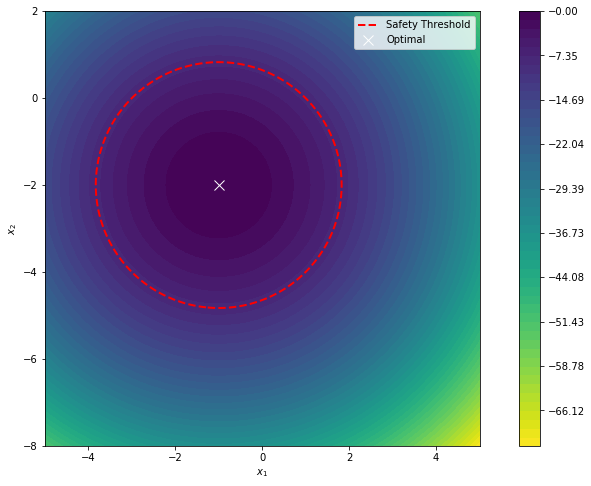

In [3]:
fig, ax, legend = plot_function(x_1, x_2, y, SafeThres)
plot_optimal(x_matrix[opt_pos,:], fig, ax, legend)
plt.show()

Safe seeds:
 X = [[-0.33066132 -4.01202405]]
 y = [[-4.49625504]]


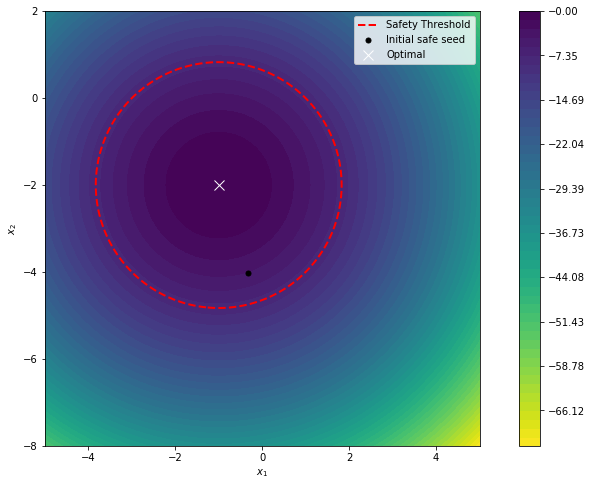

In [4]:
#Random selection (initial safe seed)
from numpy.random import default_rng
random_seed = 42
rng = default_rng(random_seed)
x_safe_seed, y_safe_seed = get_safe_seeds(rng, x_matrix, y, SafeThres, n=1)

fig, ax, legend = plot_function(x_1, x_2, y, SafeThres)
fig, ax, legend = plot_safe_seed(x_safe_seed, fig, ax, legend)
plot_optimal(x_matrix[opt_pos,:], fig, ax, legend)
plt.show()

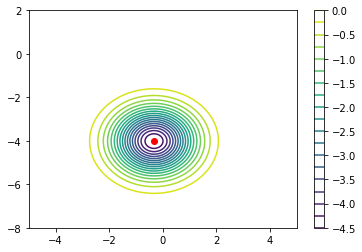

In [5]:
def run_safeopt(opt, fun, iterations, plot=False):
    for i in range(iterations):
        # Obtain next query point
        x_next = opt.optimize()
        # Get a measurement from the real system
        y_meas = fun(x_next)
        # Add this to the GP model
        opt.add_new_data_point(x_next, y_meas)
        print(f'evals={opt.t}\tx_next={x_next}\ty={y_meas}\tsafe={y_meas >= SafeThres}')
        if plot: opt.plot(500)

def safeopt_stats(opt, fun):
    emax = opt.get_maximum()
    print(f'Estimated maximum = {emax} true_y = {fun(emax[0])}')
    print(f'Max found: {np.max(opt.y)}')
    print(f'Number of failures: {np.sum(opt.y < opt.fmin)}')
    
# Measurement noise, I will add the variance soon
noise_var = 0.00 ** 2
# Define Kernel (2-dimensional RBF kernel)
kernel = GPy.kern.RBF(input_dim=len(bounds), ARD=True)
# The statistical model of our objective function
gp = GPy.models.GPRegression(x_safe_seed, y_safe_seed, kernel, noise_var=noise_var)

# The optimization routine
# FIXME: Why beta = 1.96 ?
opt = safeopt.SafeOpt(gp, parameter_set=x_matrix, fmin=[SafeThres], lipschitz=lipschitz, beta = 1.96)
# here, use lipschitz=None for modified safeopt
# opt = safeopt.SafeOpt(gp, parameter_set=x_matrix, fmin=[SafeThres], lipschitz=None, beta = 1.96)
# Plot initial safe seed
opt.plot(500)

evals=2	x_next=[-5. -8.]	y=-52.0	safe=False
evals=3	x_next=[ 4.31863727 -8.        ]	y=-64.28790245822304	safe=False
evals=4	x_next=[ 5.         -1.00601202]	y=-36.98801209633696	safe=False
evals=5	x_next=[-5.         -0.04408818]	y=-19.825591061883284	safe=False
evals=6	x_next=[0.250501 2.      ]	y=-17.563752756013027	safe=False
evals=7	x_next=[-0.69138277 -8.        ]	y=-36.09524459741125	safe=False
evals=8	x_next=[-4.51903808 -4.03206413]	y=-16.51291360275662	safe=False
evals=9	x_next=[ 3.43687375 -4.39278557]	y=-25.411271440676934	safe=False
evals=10	x_next=[-1.65330661 -0.86573146]	y=-1.7133746450817466	safe=True
evals=11	x_next=[3.67735471 2.        ]	y=-37.87764707772258	safe=False


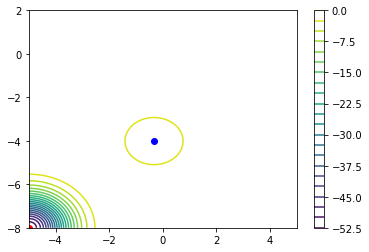

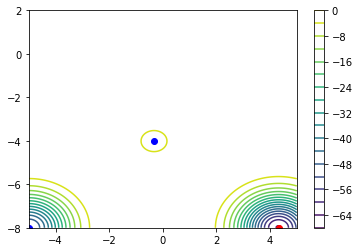

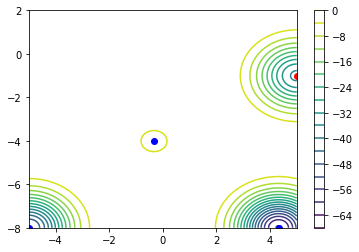

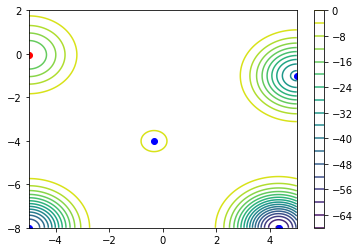

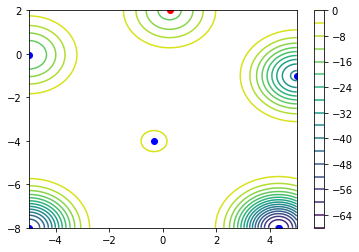

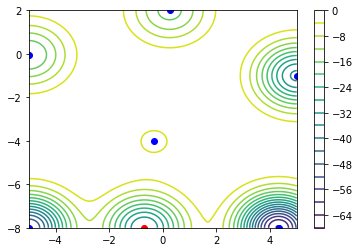

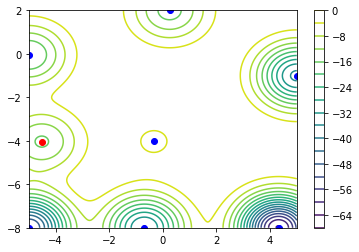

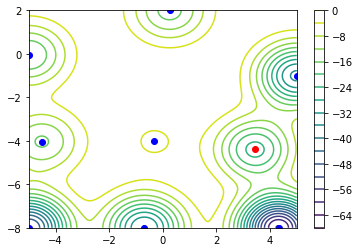

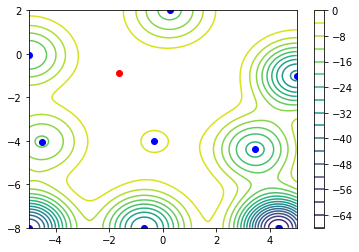

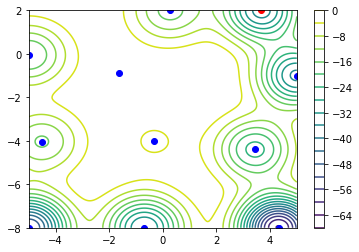

In [6]:
# do 10 iterations
run_safeopt(opt, fun, 10, plot=True)

Estimated maximum = (array([-1.65330661, -0.86573146]), -1.713570629083893) true_y = -1.7133746450817466
Max found: -1.7133746450817466
Number of failures: 9


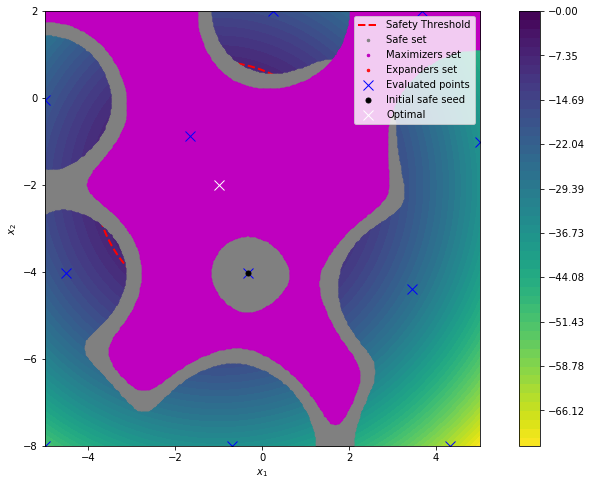

In [7]:
safeopt_stats(opt, fun)
plot_all(x_1, x_2, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])

evals=12	x_next=[ 1.69338677 -1.20641283]	y=-7.884112915209175	safe=True
evals=13	x_next=[-2.83567134  2.        ]	y=-19.36968927835631	safe=False
evals=14	x_next=[ 1.73346693 -6.63727455]	y=-28.976156722262154	safe=False
evals=15	x_next=[-2.65531062 -6.05611222]	y=-19.192099630121966	safe=False
evals=16	x_next=[-2.4749499 -3.0501002]	y=-3.278187637800653	safe=True
evals=17	x_next=[-5.  2.]	y=-32.0	safe=False
evals=18	x_next=[-5.         -2.16833667]	y=-16.028337235593433	safe=False
evals=19	x_next=[ 1.65330661 -3.33066132]	y=-8.810695539375343	safe=False
evals=20	x_next=[1.81362725 0.65731463]	y=-14.977819366187282	safe=False
evals=21	x_next=[-0.13026052 -2.02805611]	y=-0.7572339066911381	safe=True
evals=22	x_next=[-0.07014028  0.09619238]	y=-5.258661611800756	safe=True
evals=23	x_next=[-0.49098196 -5.63527054]	y=-13.474291267906553	safe=False
evals=24	x_next=[-3.43687375 -1.04609218]	y=-6.848293781952681	safe=True
evals=25	x_next=[-1.55310621  0.89779559]	y=-8.703145770498908	safe=Fa

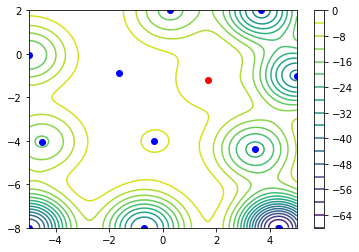

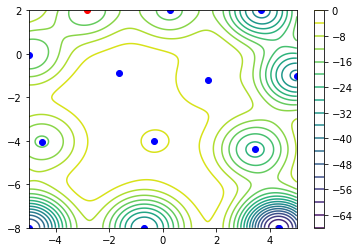

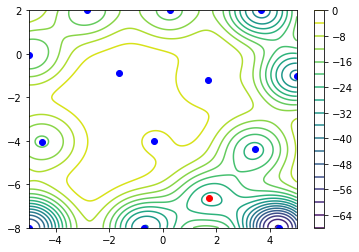

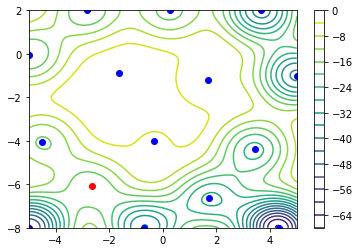

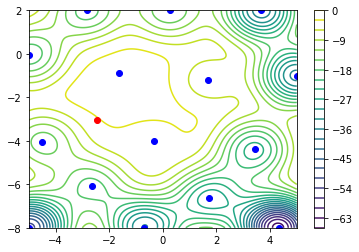

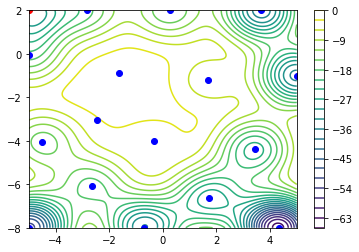

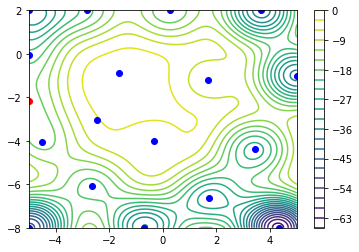

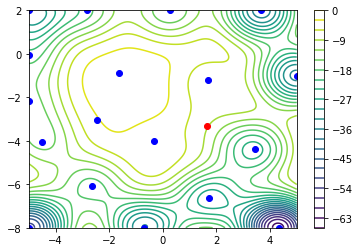

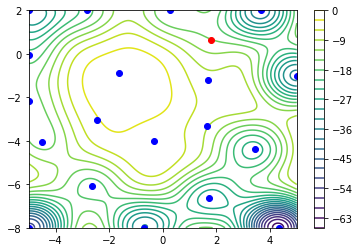

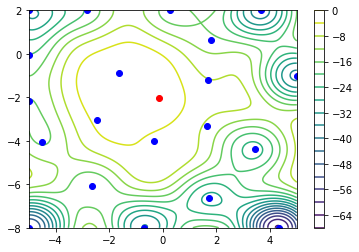

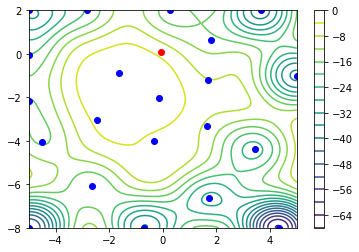

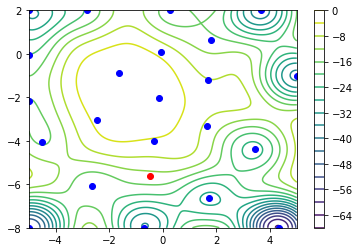

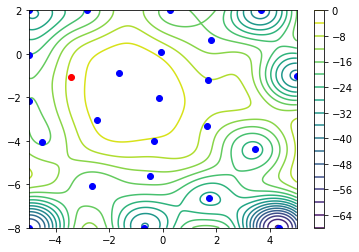

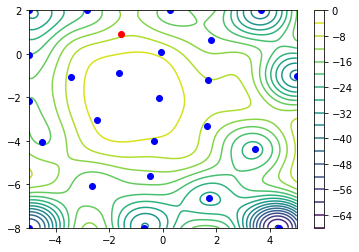

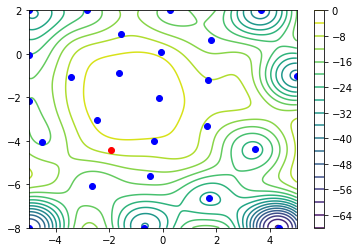

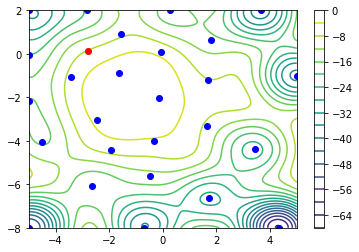

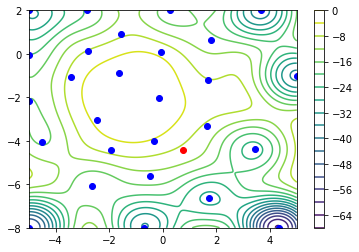

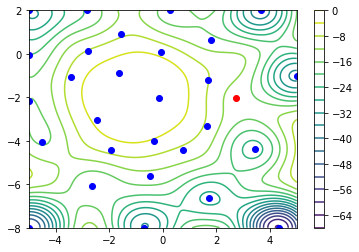

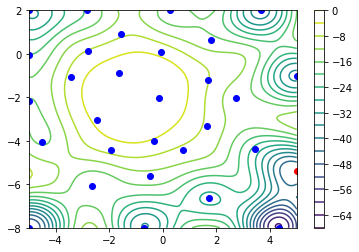

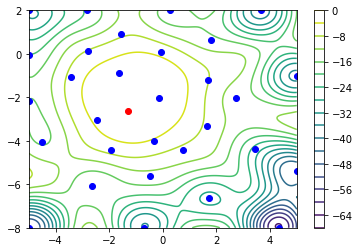

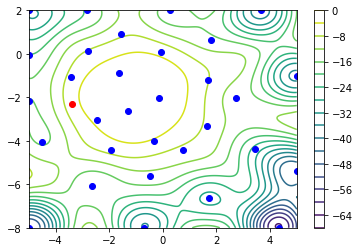

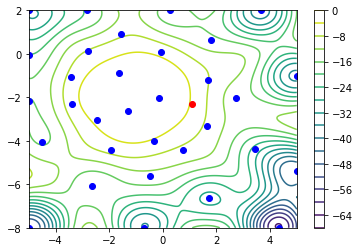

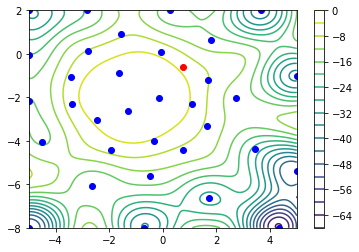

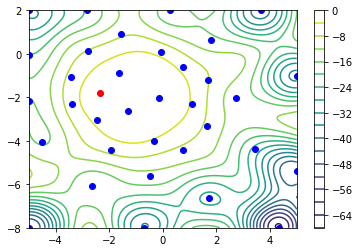

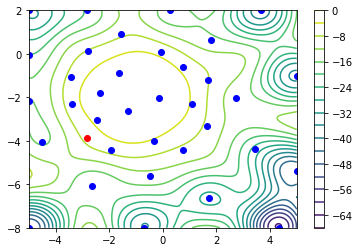

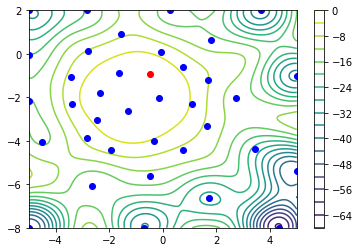

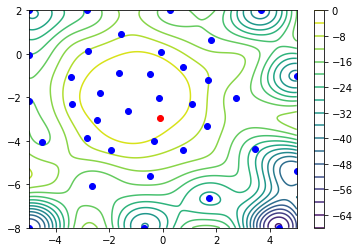

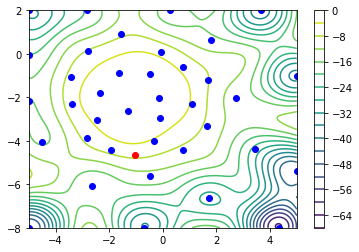

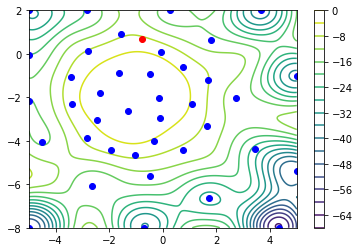

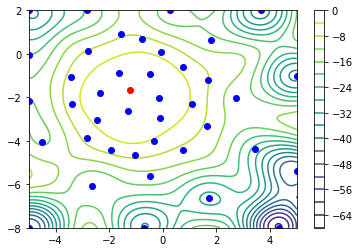

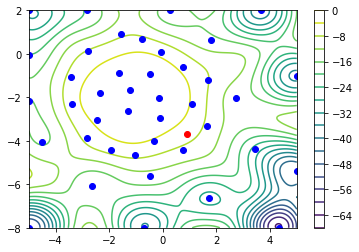

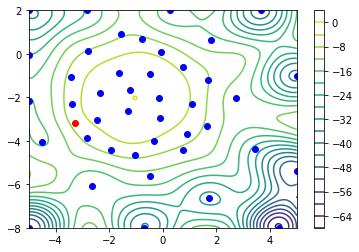

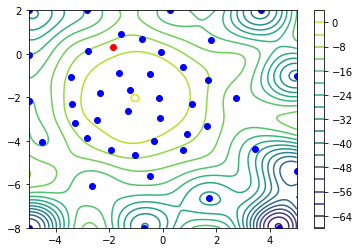

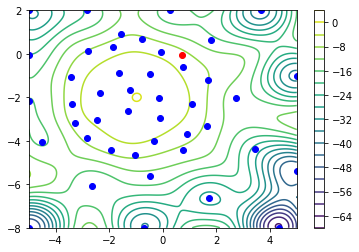

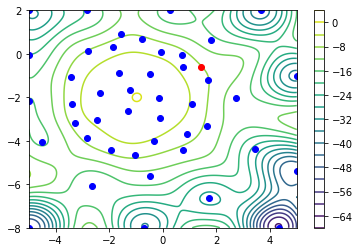

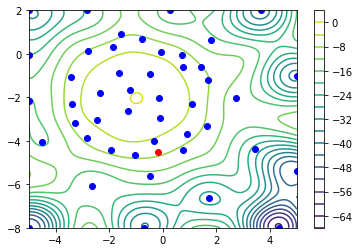

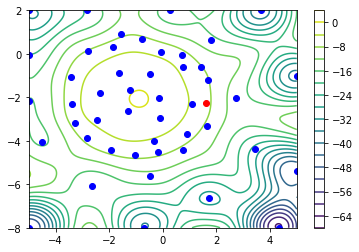

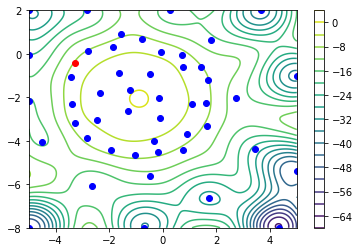

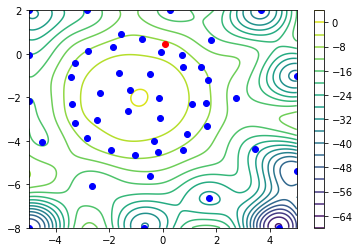

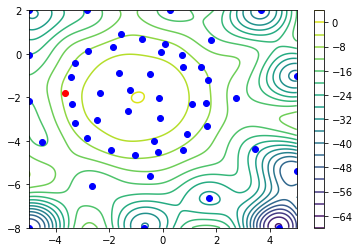

In [8]:
# do 40 more iterations (so far, 50 iterations)
run_safeopt(opt, fun, 40, plot=True)

Estimated maximum = (array([-1.09218437, -1.88777555]), -0.09643361484080583) true_y = -0.021092284769940767
Max found: -0.15579053899381937
Number of failures: 21


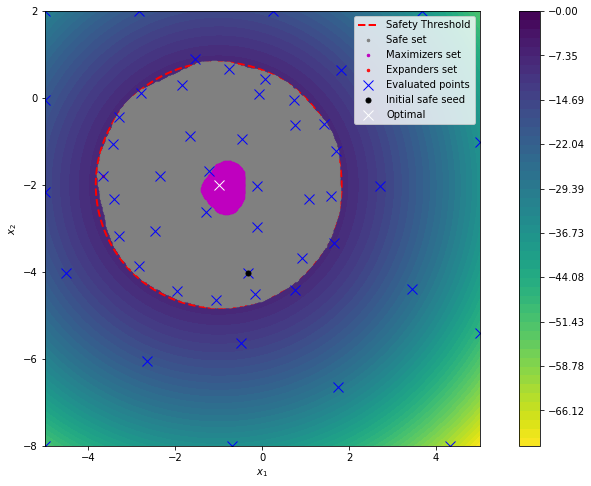

In [9]:
safeopt_stats(opt, fun)
plot_all(x_1, x_2, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])

In [ ]:
#do 60 iterations (so far 100 iterations)
run_safeopt(opt, fun, 60, plot=False) # This is very slow!

evals=52	x_next=[-3.63727455 -2.56913828]	y=-7.279135425158935	safe=True
evals=53	x_next=[-1.65330661 -2.16833667]	y=-0.45514676647884966	safe=True
evals=54	x_next=[ 1.59318637 -2.8496994 ]	y=-7.446604632109909	safe=True
evals=55	x_next=[-2.43486974 -4.35270541]	y=-7.594073919381851	safe=True
evals=56	x_next=[-1.55310621 -4.69338677]	y=-7.560258794141389	safe=True


In [ ]:
safeopt_stats(opt, fun)
plot_all(x_1, x_2, y, SafeThres, opt, x_safe_seed, x_matrix[opt_pos,:])